# **Capstone Project: Partner Insight - New Acquisition**

# ------------------- Import Basic Module -------------------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

# ------------------- Import Data -------------------

In [2]:
import pandas as pd
df = pd.read_csv('data_partner_sales.txt',delimiter='|')

# ------------------- Feature Engineer -------------------

In [3]:
df['Date'] = pd.to_datetime(df['SALES_DATE'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['year_month'] = df['Date'].apply(lambda x: x.strftime('%Y-%m'))
df.columns = df.columns.str.lower()

Check Partner has Null register date

In [5]:
# replace nan value from field partner_status, province_eng, district_en, sub_district_en to Unidentified
df['partner_status'].fillna('Unidentified', inplace=True)
df['province_eng'].fillna('Unidentified', inplace=True)
df['district_en'].fillna('Unidentified', inplace=True)
df['sub_district_en'].fillna('Unidentified', inplace=True)


In [6]:
check_null = df[df['register_date'].isnull()]

Register Date is Null come from Employee and Account Executive

In [7]:
check_null['prefix'].value_counts(normalize=True)

prefix
01    0.876611
      0.091113
Q0    0.013336
90    0.010871
80    0.003922
06    0.002353
KS    0.001457
02    0.000224
TE    0.000112
Name: proportion, dtype: float64

## Create Dataframe with Filter Year and Month

In [8]:
# create dataframe from df with year = 2023 and month in 8,9,10,11
df_select = df[(df['year']==2023) & (df['month'].isin([8,9,10,11]))]
df_select.shape

(109928, 22)

# ------------------- Function : Count Month Consecutive -------------------

In [10]:
def count_consecutive(row, columns):
    consecutive_count_now = 0
    max_consecutive_count = 0
    for col in columns:
        if row[col] == True:
            consecutive_count_now += 1
            if consecutive_count_now > max_consecutive_count:
                max_consecutive_count = consecutive_count_now
        else:
            consecutive_count_now = 0
    return max_consecutive_count

In [11]:
def sum_consecutive(row, columns):
    consecutive_sum_now = 0
    max_consecutive_sum = 0
    for col in columns:
        if row[col] != 0:
            consecutive_sum_now += 1
            if consecutive_sum_now > consecutive_sum_now:
                consecutive_sum_now = consecutive_sum_now
        else:
            consecutive_count_now = 0
    return consecutive_sum_now

In [12]:
def create_boolean_column(df,columns):
    for col in columns:
        df[col + '_flag'] = df[col].fillna(0).apply(lambda x: True if x > 0 else False)
    return

# ------------------- EDA Data -------------------

View Total partner type in dataframe and Status

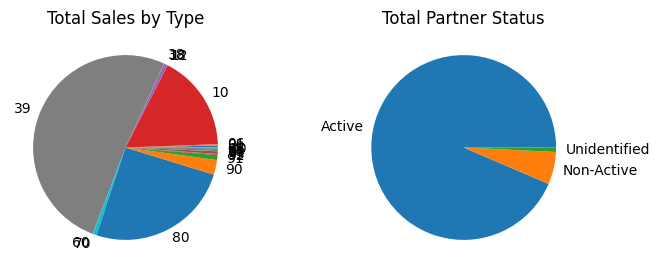

In [13]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
df_select.groupby('prefix')['total'].sum().plot(kind='pie',ax=ax[0])
ax[0].set_title('Total Sales by Type')
ax[0].set_ylabel('')
df_select.groupby('partner_status')['total'].sum().plot(kind='pie',ax=ax[1])
ax[1].set_title('Total Partner Status')
ax[1].set_ylabel('')
plt.show()


## *Sales Rate by partner and month*

In [14]:
df_sales_rate = df_select.groupby(['month','partner_code'])['sales_date'].nunique().reset_index()
df_sales_rate.columns = ['month','partner_code','count']
df_sales_rate = df_sales_rate.pivot(index='partner_code',columns='month',values='count').reset_index()
df_sales_rate.columns = ['partner_code','sale_rate_m4','sale_rate_m3','sale_rate_m2','sale_rate_m1']
df_sales_rate.head(5)

,partner_code,sale_rate_m4,sale_rate_m3,sale_rate_m2,sale_rate_m1
0,01009075,NaN,1.0,2.0,1.0
1,01010104,NaN,2.0,NaN,NaN
2,01011451,1.0,1.0,NaN,1.0
3,01011709,NaN,NaN,NaN,1.0
4,01015170,3.0,1.0,2.0,NaN


In [15]:
# in df_sales_rate set sale_rate_m4,sale_rate_m3,sale_rate_m2,sale_rate_m1 to 0 if null and set type to boolean
df_sales_rate = df_sales_rate.fillna(0)
df_sales_rate['sale_flag_m4'] = df_sales_rate['sale_rate_m4'].astype('bool')
df_sales_rate['sale_flag_m3'] = df_sales_rate['sale_rate_m3'].astype('bool')
df_sales_rate['sale_flag_m2'] = df_sales_rate['sale_rate_m2'].astype('bool')
df_sales_rate['sale_flag_m1'] = df_sales_rate['sale_rate_m1'].astype('bool')
df_sales_rate['sales_month'] = df_sales_rate['sale_flag_m4'].astype('int') + df_sales_rate['sale_flag_m3'].astype('int') + df_sales_rate['sale_flag_m2'].astype('int') + df_sales_rate['sale_flag_m1'].astype('int')

In [16]:
cols = ['sale_flag_m4','sale_flag_m3','sale_flag_m2','sale_flag_m1']

df_sales_rate['sales_consecutive'] = df_sales_rate.apply(lambda x: count_consecutive(x, cols), axis=1)
df_sales_rate.head()

,partner_code,sale_rate_m4,sale_rate_m3,sale_rate_m2,sale_rate_m1,sale_flag_m4,sale_flag_m3,sale_flag_m2,sale_flag_m1,sales_month,sales_consecutive
0,01009075,0.0,1.0,2.0,1.0,False,True,True,True,3,3
1,01010104,0.0,2.0,0.0,0.0,False,True,False,False,1,1
2,01011451,1.0,1.0,0.0,1.0,True,True,False,True,3,2
3,01011709,0.0,0.0,0.0,1.0,False,False,False,True,1,1
4,01015170,3.0,1.0,2.0,0.0,True,True,True,False,3,3


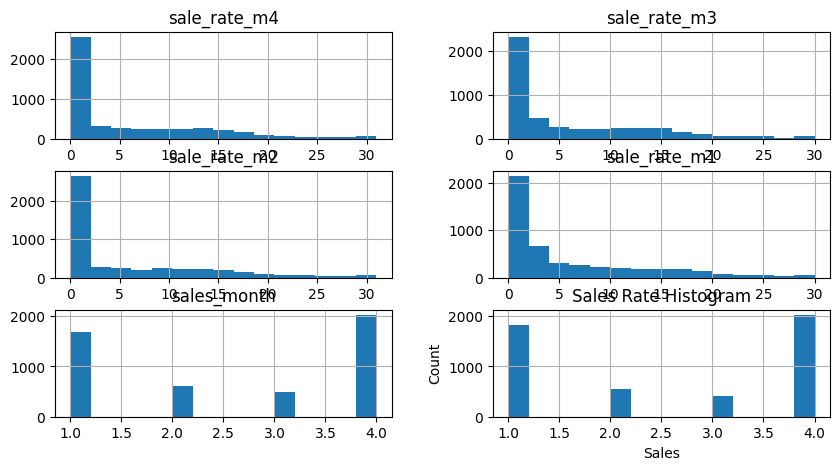

In [17]:
df_sales_rate.hist(bins=15, figsize=(10,5))
plt.title('Sales Rate Histogram')
plt.xlabel('Sales')
plt.ylabel('Count')
plt.show()


## *Revenue Rate by partner and month*

In [18]:
df_revenue_rate = df_select.groupby(['month','partner_code'])['revenue'].sum().reset_index()
df_revenue_rate.columns = ['month','partner_code','count']
df_revenue_rate = df_revenue_rate.pivot(index='partner_code',columns='month',values='count').reset_index()
df_revenue_rate.columns = ['partner_code','rev_m4','rev_m3','rev_m2','rev_m1']
df_revenue_rate.head(5)

,partner_code,rev_m4,rev_m3,rev_m2,rev_m1
0,01009075,NaN,0.0,0.0,0.0
1,01010104,NaN,2798.0,NaN,NaN
2,01011451,0.0,0.0,NaN,0.0
3,01011709,NaN,NaN,NaN,399.0
4,01015170,15888.0,7500.0,24500.0,NaN


In [19]:
df_revenue_rate = df_revenue_rate.fillna(0)
df_revenue_rate['rev_flag_m4'] = df_revenue_rate['rev_m4'].astype('bool')
df_revenue_rate['rev_flag_m3'] = df_revenue_rate['rev_m3'].astype('bool')
df_revenue_rate['rev_flag_m2'] = df_revenue_rate['rev_m2'].astype('bool')
df_revenue_rate['rev_flag_m1'] = df_revenue_rate['rev_m1'].astype('bool')
df_revenue_rate['rev_month'] = df_revenue_rate['rev_flag_m4'].astype('int') + df_revenue_rate['rev_flag_m3'].astype('int') + df_revenue_rate['rev_flag_m2'].astype('int') + df_revenue_rate['rev_flag_m1'].astype('int')

In [20]:
cols = ['rev_flag_m4','rev_flag_m3','rev_flag_m2','rev_flag_m1']

df_revenue_rate['rev_consecutive'] = df_revenue_rate.apply(lambda x: count_consecutive(x, cols), axis=1)
df_revenue_rate.head()

,partner_code,rev_m4,rev_m3,rev_m2,rev_m1,rev_flag_m4,rev_flag_m3,rev_flag_m2,rev_flag_m1,rev_month,rev_consecutive
0,01009075,0.0,0.0,0.0,0.0,False,False,False,False,0,0
1,01010104,0.0,2798.0,0.0,0.0,False,True,False,False,1,1
2,01011451,0.0,0.0,0.0,0.0,False,False,False,False,0,0
3,01011709,0.0,0.0,0.0,399.0,False,False,False,True,1,1
4,01015170,15888.0,7500.0,24500.0,0.0,True,True,True,False,3,3


## *Churn Rate by partner and month*

In [21]:
# create new dataframe from df_select with count column churn by month and partner_code
df_churn_rate = df_select.groupby(['month','partner_code'])['churn'].sum().reset_index()
df_churn_rate.columns = ['month','partner_code','count']
df_churn_rate = df_churn_rate.pivot(index='partner_code',columns='month',values='count').reset_index()
df_churn_rate.columns = ['partner_code','churn_m4','churn_m3','churn_m2','churn_m1']
df_churn_rate.head(5)

,partner_code,churn_m4,churn_m3,churn_m2,churn_m1
0,01009075,NaN,0.0,0.0,0.0
1,01010104,NaN,0.0,NaN,NaN
2,01011451,0.0,0.0,NaN,0.0
3,01011709,NaN,NaN,NaN,0.0
4,01015170,0.0,0.0,0.0,NaN


In [22]:
df_churn_rate = df_churn_rate.fillna(0)
df_churn_rate['churn_flag_m4'] = df_churn_rate['churn_m4'].astype('bool')
df_churn_rate['churn_flag_m3'] = df_churn_rate['churn_m3'].astype('bool')
df_churn_rate['churn_flag_m2'] = df_churn_rate['churn_m2'].astype('bool')
df_churn_rate['churn_flag_m1'] = df_churn_rate['churn_m1'].astype('bool')
df_churn_rate['churn_month'] = df_churn_rate['churn_flag_m4'].astype('int') + df_churn_rate['churn_flag_m3'].astype('int') + df_churn_rate['churn_flag_m2'].astype('int') + df_churn_rate['churn_flag_m1'].astype('int')

In [23]:
cols = ['churn_flag_m4','churn_flag_m3','churn_flag_m2','churn_flag_m1']

df_churn_rate['churn_consecutive'] = df_churn_rate.apply(lambda x: count_consecutive(x, cols), axis=1)

## *Total Sales, Total Revenue and Total Churn by partner and month*

In [24]:
df_sales = df_select.groupby(['partner_code'])[['total','revenue','churn']].sum().reset_index()
df_sales.columns = ['partner_code','total_sales','total_revenue','total_churn']
df_sales.shape

(4808, 4)

## *Partner Aging*

In [25]:
# create df_partner with uniq partner_code, partner_status and partner_aging from df_select
df_partner = df_select[['partner_code','partner_status','partner_aging']].drop_duplicates()
df_partner['partner_ageing_mth'] = df_partner['partner_aging']/30
df_partner['partner_ageing_yr'] = df_partner['partner_aging']/365
df_partner.shape

(4809, 5)

<Axes: xlabel='partner_status', ylabel='partner_ageing_yr'>

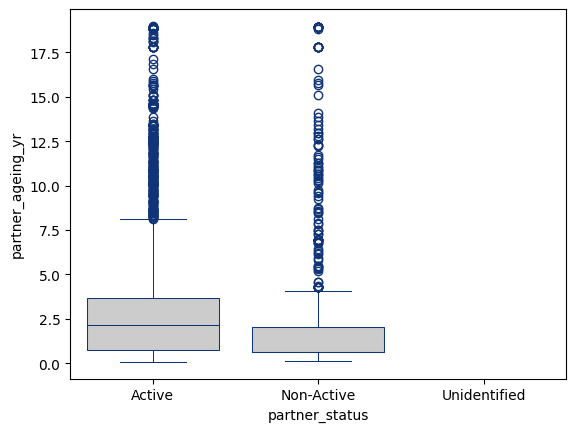

In [26]:
sns.boxplot(data=df_partner, x='partner_status', y='partner_ageing_yr',color=".8", linecolor="#137", linewidth=.75)

## **Summary List of Dataframe**

**List of dataframe**

| Major | No | Name | Description |
|-----|----|------|---------------|
|N| 1 | df_sales_rate | The number of sales that occur each month. (count sales date) | 
|N| 2 | df_revenue_rate | The number of revenue that occur each month. (count sales date) | 
|N| 3 | df_churn_rate | The number of cancellations that occur in the month |
|N| 4 | df_sales | Summary sale, revenue and churn by partner. |
|Y| 5 | df_partner | Aging by partner (compare register and report date). |

**Final Dataframe**

| No | Name | Desccription |
|----|------|--------------|
| 1 | df_performance | by merging of 5 dataframe |


### **Create Dataframe**

In [27]:
df_performance = pd.merge(df_partner,df_sales,on='partner_code',how='left')
df_performance = pd.merge(df_performance,df_sales_rate,on='partner_code',how='left')
df_performance = pd.merge(df_performance,df_revenue_rate,on='partner_code',how='left')
df_performance = pd.merge(df_performance,df_churn_rate,on='partner_code',how='left')
df_performance.fillna(0,inplace=True)

print(f' Total Partner : {df_performance.shape[0]} \n And {df_performance.shape[1] } feature')


 Total Partner : 4809 
 And 38 feature


Correlation of feature

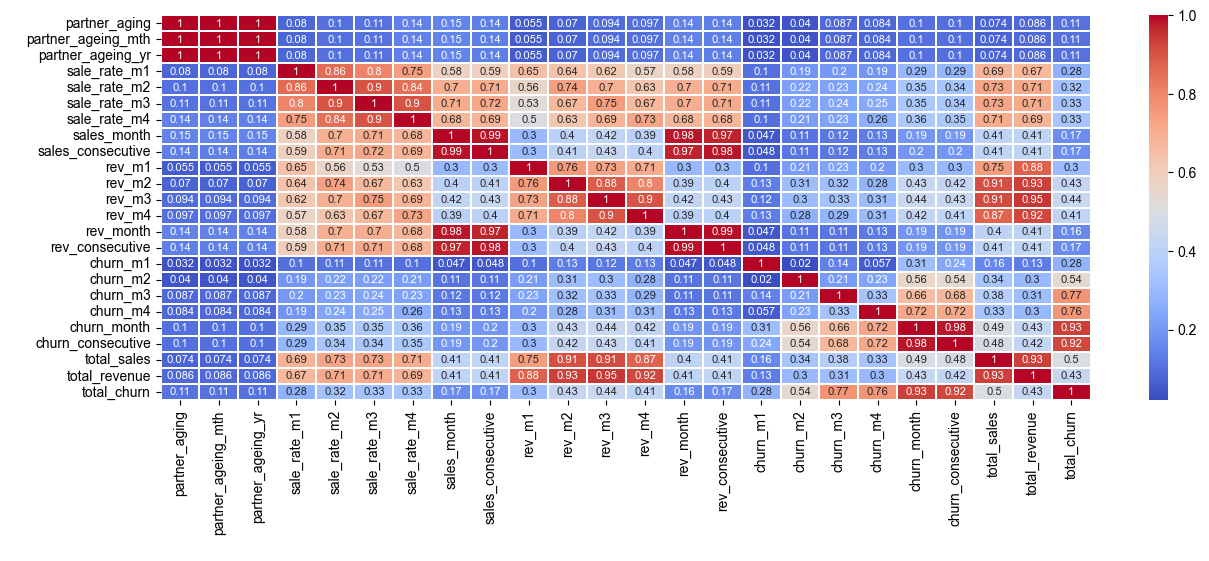

In [28]:
plt.figure(figsize=(15,5))
sns.heatmap(df_performance[['partner_aging','partner_ageing_mth','partner_ageing_yr'
                            ,'sale_rate_m1','sale_rate_m2','sale_rate_m3','sale_rate_m4'
                            ,'sales_month','sales_consecutive'
                            ,'rev_m1','rev_m2','rev_m3','rev_m4'
                            ,'rev_month','rev_consecutive'
                            ,'churn_m1','churn_m2','churn_m3','churn_m4'
                            ,'churn_month','churn_consecutive'
                            ,'total_sales','total_revenue','total_churn'

                            ]].corr()
            ,annot=True
            ,cmap='coolwarm'
            ,linewidths=0.2
            ,annot_kws={'size':8})
sns.set(font_scale=0.8)


Box and Whisker

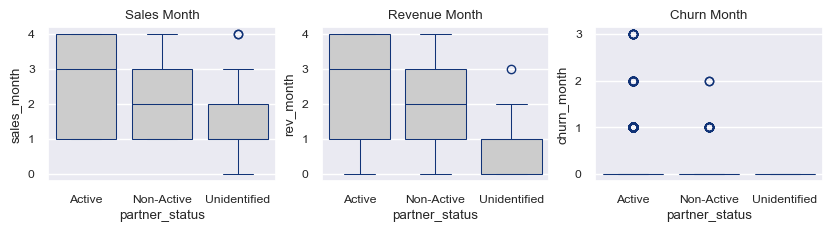

In [29]:
# create box and whisker plot from df_performance
plt.figure(figsize=(10,2))

plt.subplot(1,3,1)
sns.boxplot(data=df_performance, x='partner_status', y='sales_month',color=".8", linecolor="#137", linewidth=.75)
plt.title('Sales Month')

plt.subplot(1,3,2)
sns.boxplot(data=df_performance, x='partner_status', y='rev_month',color=".8", linecolor="#137", linewidth=.75)
plt.title('Revenue Month')

plt.subplot(1,3,3)
sns.boxplot(data=df_performance, x='partner_status', y='churn_month',color=".8", linecolor="#137", linewidth=.75)
plt.title('Churn Month')

plt.show()

# **Data for Model 1 - Select Partner Status Active and Aging between 1 - 4 month**

In [30]:
df_performance_1 = df_performance[(df_performance['partner_status']=='Active') & (df_performance['partner_ageing_yr'].between(1, 4))]
df_performance_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1698 entries, 4 to 4805
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   partner_code        1698 non-null   object 
 1   partner_status      1698 non-null   object 
 2   partner_aging       1698 non-null   float64
 3   partner_ageing_mth  1698 non-null   float64
 4   partner_ageing_yr   1698 non-null   float64
 5   total_sales         1698 non-null   float64
 6   total_revenue       1698 non-null   float64
 7   total_churn         1698 non-null   float64
 8   sale_rate_m4        1698 non-null   float64
 9   sale_rate_m3        1698 non-null   float64
 10  sale_rate_m2        1698 non-null   float64
 11  sale_rate_m1        1698 non-null   float64
 12  sale_flag_m4        1698 non-null   object 
 13  sale_flag_m3        1698 non-null   object 
 14  sale_flag_m2        1698 non-null   object 
 15  sale_flag_m1        1698 non-null   object 
 16  sales_month

In [31]:
df_performance_1.columns

Index(['partner_code', 'partner_status', 'partner_aging', 'partner_ageing_mth',
       'partner_ageing_yr', 'total_sales', 'total_revenue', 'total_churn',
       'sale_rate_m4', 'sale_rate_m3', 'sale_rate_m2', 'sale_rate_m1',
       'sale_flag_m4', 'sale_flag_m3', 'sale_flag_m2', 'sale_flag_m1',
       'sales_month', 'sales_consecutive', 'rev_m4', 'rev_m3', 'rev_m2',
       'rev_m1', 'rev_flag_m4', 'rev_flag_m3', 'rev_flag_m2', 'rev_flag_m1',
       'rev_month', 'rev_consecutive', 'churn_m4', 'churn_m3', 'churn_m2',
       'churn_m1', 'churn_flag_m4', 'churn_flag_m3', 'churn_flag_m2',
       'churn_flag_m1', 'churn_month', 'churn_consecutive'],
      dtype='object')

Box and Whisker

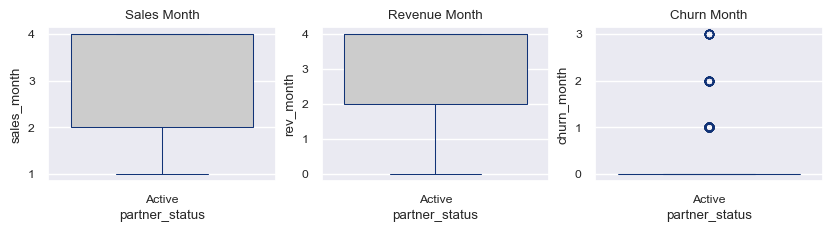

In [32]:
plt.figure(figsize=(10,2))

plt.subplot(1,3,1)
sns.boxplot(data=df_performance_1, x='partner_status', y='sales_month',color=".8", linecolor="#137", linewidth=.75)
plt.title('Sales Month')

plt.subplot(1,3,2)
sns.boxplot(data=df_performance_1, x='partner_status', y='rev_month',color=".8", linecolor="#137", linewidth=.75)
plt.title('Revenue Month')

plt.subplot(1,3,3)
sns.boxplot(data=df_performance_1, x='partner_status', y='churn_month',color=".8", linecolor="#137", linewidth=.75)
plt.title('Churn Month')

plt.show()
plt.show()

## **Model: K-Mean Clustering**

/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/8b/h71yb7vj7b513jqfhq12rrx00000gn/T/ipykernel_4468/3368387543.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_performance_1['cluster_k'] = kn_model.labels_
/var/folders/8b/h71yb7vj7b513jqfhq12rrx00000gn/T/ipykernel_4468/3368387543.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks() // 1e4)


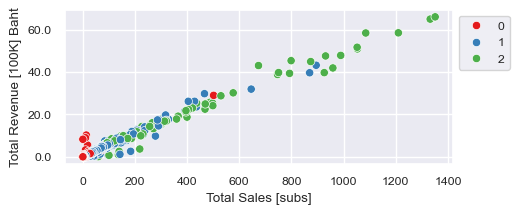

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_performance_1_scaled = scaler.fit_transform(df_performance_1[[
    'partner_ageing_yr'
                            ,'sales_consecutive'
                            ,'rev_consecutive'
                            ,'churn_consecutive'
                            ]])

kn_model = KMeans(n_clusters=3, random_state=42).fit(df_performance_1_scaled)
df_performance_1['cluster_k'] = kn_model.labels_

centers = np.array(kn_model.cluster_centers_)

# Plot Chart
plt.figure(figsize=(5,2))
ax = sns.scatterplot(x='total_sales',y='total_revenue',hue='cluster_k',data=df_performance_1,palette='Set1')
#, centers[:,1], marker="x", color='b',s=100)
ax.set_yticklabels(ax.get_yticks() // 1e4)
plt.ylabel('Total Revenue [100K] Baht')
plt.xlabel('Total Sales [subs]')
#plt.title('Cluster by Partner Aging and Total Sales')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [59]:
df_performance_1['cluster_k'].value_counts(normalize=True)  

cluster_k
1    0.606596
0    0.320377
2    0.073027
Name: proportion, dtype: float64

Shilouette score

In [60]:
from sklearn.metrics import silhouette_score

kn_score = silhouette_score(df_performance_1_scaled, kn_model.labels_)
print(f"Silhouette Score: {kn_score}")

Silhouette Score: 0.6201183022654112


Elbow Plot for checking recommend K

/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of

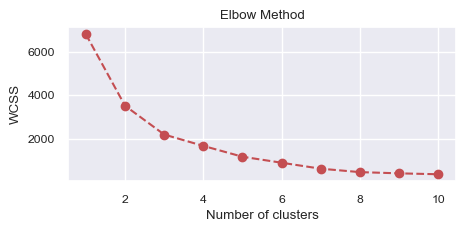

In [62]:
# find wcss from kn_model
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_performance_1_scaled)
    wcss.append(kmeans.inertia_)

# plot chart from wcss
plt.figure(figsize=(5,2))
plt.plot(range(1, 11), wcss,marker='o',linestyle='--',color='r')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()


/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of

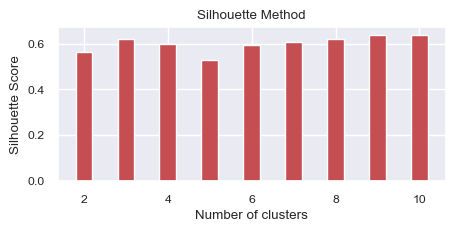

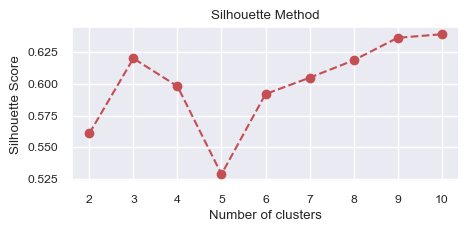

In [63]:
from sklearn.metrics import silhouette_score
sil = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k).fit(df_performance_1_scaled)
    preds = kmeans.fit_predict(df_performance_1_scaled)
    sil.append(silhouette_score(df_performance_1_scaled, preds, metric = 'euclidean'))

# Plotting a bar graph to compare the results
plt.figure(figsize=(5,2))
plt.bar(range(2, 11), sil, color = 'r', width = 0.4)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.figure(figsize=(5,2))
plt.plot(range(2, 11), sil,marker='o',linestyle='--',color='r')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

## **Model: Agglomerative Clustering**

/Users/meepoom/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


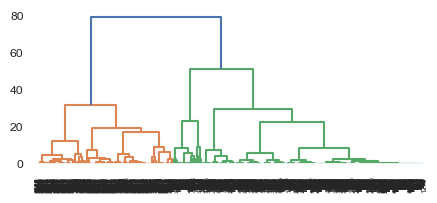

In [64]:
# create predict model from df_performance_1 with scaling by using AgglomerativeClustering and plot in dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

ac_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
ac_model.fit(df_performance_1_scaled)
labels = ac_model.labels_

plt.figure(figsize=(5,2))
#plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('Index')
#plt.ylabel('distance')
dendrogram(linkage(df_performance_1_scaled, 'ward'))

plt.show()

## **Model: DBSCAN**

/var/folders/8b/h71yb7vj7b513jqfhq12rrx00000gn/T/ipykernel_4468/3557930196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_performance_1['cluster_d'] = dbscan.labels_
/var/folders/8b/h71yb7vj7b513jqfhq12rrx00000gn/T/ipykernel_4468/3557930196.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks() // 1e4)


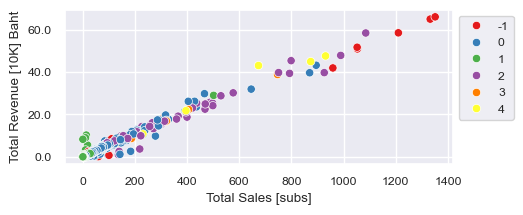

In [65]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=5)
dbscan.fit(df_performance_1_scaled)
df_performance_1['cluster_d'] = dbscan.labels_
df_performance_1.head(5)

plt.figure(figsize=(5,2))
ax = sns.scatterplot(x='total_sales',y='total_revenue',hue='cluster_d',data=df_performance_1,palette='Set1')
#plt.title('Cluster by Partner Aging and Total Sales')

ax.set_yticklabels(ax.get_yticks() // 1e4)

plt.xlabel('Total Sales [subs]')
plt.ylabel('Total Revenue [10K] Baht')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Shilouette Score <br>
คำนวณระยะห่างระหว่างกลุ่ม เทียบกับระยะห่างระหว่างจุดในกลุ่มเดียวกัน ค่าที่ดีที่สุดคือ 1 และแย่ที่สุดคือ -1

In [67]:
silhouette_avg = silhouette_score(df_performance_1_scaled, dbscan.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6102574469028544


In [68]:
silhouette_avg = silhouette_score(df_performance_1_scaled, dbscan.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6102574469028544


In [69]:
df_performance_1['cluster_d'].value_counts(normalize=True)  

cluster_d
 0    0.606596
 1    0.318021
 2    0.057715
-1    0.008834
 3    0.005300
 4    0.003534
Name: proportion, dtype: float64

Davies-Bouldin Index <br>
คำนวณการกระจายของข้อมูลในกลุ่มกับการแยกห่างของแต่ละกลุ่ม ค่าที่ดีที่สุดคือ 0

In [70]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(df_performance_1_scaled, labels)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.6490473870125714


In [71]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(df_performance_1_scaled, labels)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.6490473870125714


Calinski-Harabasz Index <br>
คำนวณการกระจายของข้อมูลในกลุ่มเดียวกัน เทียบกับการกระจายระหว่างกลุ่ม ค่ายิ่งสูงยิ่งดี

In [72]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(df_performance_1_scaled, labels)
print(f"Calinski-Harabasz Index: {ch_score}")

Calinski-Harabasz Index: 1614.2419407546706


In [73]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(df_performance_1_scaled, labels)
print(f"Calinski-Harabasz Index: {ch_score}")

Calinski-Harabasz Index: 1614.2419407546706


#### Find Best Parameter

GridSearch

In [74]:
from sklearn.model_selection import ParameterGrid

param_grid = {'eps': [0.5, 1.0, 1.5], 'min_samples': [1, 5, 10, 15]}
grid = ParameterGrid(param_grid)

best_score = -1
best_params = None

for params in grid:
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(df_performance_1_scaled)
    silhouette_avg = silhouette_score(df_performance_1_scaled, labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params = params

print(f"Best Parameters: {best_params}")


Best Parameters: {'eps': 1.0, 'min_samples': 5}


Silhouette

In [75]:
from sklearn.metrics import silhouette_score

eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_performance_1_scaled)
        silhouette_avg = silhouette_score(df_performance_1_scaled, labels)
        print(f"eps={eps}, min_samples={min_samples}, Silhouette Score: {silhouette_avg}")


eps=0.5, min_samples=5, Silhouette Score: 0.25856577153577026
eps=0.5, min_samples=10, Silhouette Score: 0.3286470416202876
eps=0.5, min_samples=15, Silhouette Score: 0.3241146011551409
eps=1.0, min_samples=5, Silhouette Score: 0.6102574469028544
eps=1.0, min_samples=10, Silhouette Score: 0.6092393876108573
eps=1.0, min_samples=15, Silhouette Score: 0.3859887269871021
eps=1.5, min_samples=5, Silhouette Score: 0.38417379178780775
eps=1.5, min_samples=10, Silhouette Score: 0.4062203118816658
eps=1.5, min_samples=15, Silhouette Score: 0.4077148410833108


Calinski

In [76]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_performance_1_scaled)
        ch_score = calinski_harabasz_score(df_performance_1_scaled, labels)
        db_index = davies_bouldin_score(df_performance_1_scaled, labels)
        print(f"eps={eps}, min_samples={min_samples}, Calinski-Harabasz Index: {ch_score}, Davies-Bouldin Index: {db_index}")


eps=0.5, min_samples=5, Calinski-Harabasz Index: 459.67102187578365, Davies-Bouldin Index: 1.3397090628624164
eps=0.5, min_samples=10, Calinski-Harabasz Index: 605.3627502307104, Davies-Bouldin Index: 1.6980991940576449
eps=0.5, min_samples=15, Calinski-Harabasz Index: 601.7030305450947, Davies-Bouldin Index: 1.643143020212733
eps=1.0, min_samples=5, Calinski-Harabasz Index: 849.4623781444545, Davies-Bouldin Index: 1.1384231718723854
eps=1.0, min_samples=10, Calinski-Harabasz Index: 1355.722574659934, Davies-Bouldin Index: 0.7312672067524304
eps=1.0, min_samples=15, Calinski-Harabasz Index: 1039.018245228843, Davies-Bouldin Index: 1.0075693649676332
eps=1.5, min_samples=5, Calinski-Harabasz Index: 158.29260056844296, Davies-Bouldin Index: 0.8501305878495689
eps=1.5, min_samples=10, Calinski-Harabasz Index: 192.12686374143965, Davies-Bouldin Index: 2.1171837558532447
eps=1.5, min_samples=15, Calinski-Harabasz Index: 286.17028598027616, Davies-Bouldin Index: 0.8101219542731237


In [56]:
# export df_performance_1 to csv file
df_performance_1.to_csv('df_performance_1.csv',index=False)

# Result

From the resulting ratt It is not possible to conclude what the salesperson with the coefficient is, or which one. Which the analysis process still needs to be developed.

But from the initial results Makes us discover that employees have an average sales density of 1 to 500 subs,And considering deep down, we will see the density of partner and cluster clearly.Which lead to the action plan

# Recommendation and Action Plan

- Recommend.
From the density in previous slide.
The team has divided the sales range into 4 parts, each of which consists of a cluster of partner in different levels, That make company easy to focus.

- Action Plan.
Partner cluster 1: Has a small sales volume but products are high price. Companies should push this group to increase sales rate.
Partner Cluster 0: Has a large sales volume but low price and is a large group. Companies could help to find a package or improve the this group to sold high value